In [116]:
import numpy as np
import csv
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, KFold
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

In [12]:
columns =[ 
'Profile_mean',
'Profile_stdev',
'Profile_skewness',
'Profile_kurtosis',
'DM_mean',
'DM_stdev',
'DM_skewness',
'DM_kurtosis',
'label'
]

In [19]:
results = defaultdict()

In [13]:
df_base = pd.read_csv('HTRU2/HTRU_2.csv',header=None,names=columns)
X = np.array(df_base.drop(columns='label'))
y = np.array(df_base.label)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [66]:
def p_estimate_parzen_window(x, h, X, y):

    classes = np.unique(y)

    concat = np.hstack((X, np.expand_dims(y, axis=1)))

    p_list = []

    for i in classes:

        input_values_class = concat[concat[:, -1] == i, 0:-1]

        sub = (x - input_values_class) / h

        cte = 1 / (np.sqrt(2) * np.pi)

        K = np.prod(cte * np.exp(-sub.astype(float) ** 2 / 2), axis=1)

        p = sum(K)

        n_i = len(sub)

        d = len(sub[0])

        p_list.append([i, p / (n_i * (h**d))])

        p = 0

    return p_list


def probability_priori(y):
    """return a list with each priori probability"""

    pr_pb = Counter(y)

    total = sum(pr_pb.values(), 0.0)

    for key in pr_pb:
        pr_pb[key] /= total

    return pr_pb


class Parzen:
    def __init__(self, h=1):
        self.h = h

    def predict(self, x, X, y):

        pp = probability_priori(y)

        predict_parzen = []

        for x_i in x:

            parzen = p_estimate_parzen_window(x_i, self.h, X, y)

            parzen_probs = []

            for n, i in enumerate(parzen):
                num = pp[parzen[n][0]] * parzen[n][1]
                den = 0
                for k, j in enumerate(parzen):
                    den += pp[parzen[k][0]] * parzen[k][1]

                parzen_probs.append(num / den)

            predict_parzen.append(
                parzen[parzen_probs.index(max(parzen_probs))][0]
            )

        return predict_parzen

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
kf = KFold(n_splits=5)
for tr_index, tst_index in kf.split(X_train):

    parameter_h = []

    X_tr, X_val = X_train[tr_index], X_train[tst_index]
    y_tr, y_val = y_train[tr_index], y_train[tst_index]

    for h in np.linspace(0.01, 0.3, num=10):

        parzen_classifier = Parzen(h)
        parzen_predict = parzen_classifier.predict(X_val, X_tr, y_tr)

        parameter_h.append([accuracy_score(y_val, parzen_predict), h])

    h_values.append([max(parameter_h)[0], max(parameter_h)[1]])

h = max(h_values)[1]

print("Best h:", h)

/tmp/ipykernel_1102149/2269071002.py:67: RuntimeWarning: invalid value encountered in double_scalars
  parzen_probs.append(num / den)
/tmp/ipykernel_1102149/2269071002.py:67: RuntimeWarning: invalid value encountered in double_scalars
  parzen_probs.append(num / den)
/tmp/ipykernel_1102149/2269071002.py:67: RuntimeWarning: invalid value encountered in double_scalars
  parzen_probs.append(num / den)
/tmp/ipykernel_1102149/2269071002.py:67: RuntimeWarning: invalid value encountered in double_scalars
  parzen_probs.append(num / den)
/tmp/ipykernel_1102149/2269071002.py:67: RuntimeWarning: invalid value encountered in double_scalars
  parzen_probs.append(num / den)
/tmp/ipykernel_1102149/2269071002.py:67: RuntimeWarning: invalid value encountered in double_scalars
  parzen_probs.append(num / den)
/tmp/ipykernel_1102149/2269071002.py:67: RuntimeWarning: invalid value encountered in double_scalars
  parzen_probs.append(num / den)
/tmp/ipykernel_1102149/2269071002.py:67: RuntimeWarning: inval

Best h: 0.2677777777777778


In [105]:
skf = StratifiedKFold(n_splits=10)
kf = KFold(n_splits=5)

execs_accuracy = []
execs_precision = []
execs_recall = []
execs_f_measure = []

train_test_split(X,y)


for i in tqdm(range(30)):
    for train_index, test_index in skf.split(X, y):
        accuracy = []
        precision = []
        recall = []
        f_measure = []
        loss = []
        
        X_train = X[train_index]
        y_train = y[train_index]

        parzen_classifier = Parzen(h)
        parzen_predict = parzen_classifier.predict(X_test,X_train,y_train)

        accuracy.append(accuracy_score(y_test, parzen_predict))
        precision.append(precision_score(y_test, parzen_predict, average='macro',zero_division=0))
        recall.append(recall_score(y_test, parzen_predict, average='macro',zero_division=0))
        f_measure.append(f1_score(y_test, parzen_predict, average='macro',zero_division=0))

    execs_accuracy.append(np.mean(accuracy))
    execs_precision.append(np.mean(precision))
    execs_recall.append(np.mean(recall))
    execs_f_measure.append(np.mean(f_measure))

results['parzen'] = {
    'execs_accuracy': execs_accuracy,
    'execs_precision': execs_precision,
    'execs_recall': execs_recall,
    'execs_f_measure': execs_f_measure,
}

  0%|          | 0/30 [00:00<?, ?it/s]

In [74]:
execs_accuracy = []
execs_precision = []
execs_recall = []
execs_f_measure = []
execs_loss = []

skf = StratifiedKFold(n_splits=10)

for i in tqdm(range(30)):
    for train_index, test_index in skf.split(X,y):
        accuracy = []
        precision = []
        recall = []
        f_measure = []
        loss = []

        skf = StratifiedKFold(n_splits=10,shuffle=True)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegression(random_state=42,multi_class="ovr",max_iter=500).fit(X_train, y_train)
        lr_predict = clf.predict(X_test)

        accuracy.append(accuracy_score(y_test, lr_predict))
        loss.append(log_loss(y_test,lr_predict))
        precision.append(precision_score(y_test, lr_predict, average='macro',zero_division=0))
        recall.append(recall_score(y_test, lr_predict, average='macro',zero_division=0))
        f_measure.append(f1_score(y_test, lr_predict, average='macro',zero_division=0))
        
    execs_accuracy.append(np.mean(accuracy))
    execs_precision.append(np.mean(precision))
    execs_recall.append(np.mean(recall))
    execs_f_measure.append(np.mean(f_measure))
    execs_loss.append(np.mean(loss))
        
results['logistic_regression'] = {
    'execs_accuracy': execs_accuracy,
    'execs_precision': execs_precision,
    'execs_recall': execs_recall,
    'execs_f_measure': execs_f_measure,
    'execs_loss': execs_loss,
}

  0%|          | 0/30 [00:00<?, ?it/s]

In [50]:
execs_accuracy = []
execs_precision = []
execs_recall = []
execs_f_measure = []
execs_loss = []

skf = StratifiedKFold(n_splits=10)

for i in tqdm(range(30)):
    for train_index, test_index in skf.split(X,y):
        accuracy = []
        precision = []
        recall = []
        f_measure = []
        loss = []

        skf = StratifiedKFold(n_splits=10,shuffle=True)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = GaussianNB().fit(X_train, y_train)
        lr_predict = clf.predict(X_test)

        accuracy.append(accuracy_score(y_test, lr_predict))
        loss.append(log_loss(y_test,lr_predict))
        precision.append(precision_score(y_test, lr_predict, average='macro',zero_division=0))
        recall.append(recall_score(y_test, lr_predict, average='macro',zero_division=0))
        f_measure.append(f1_score(y_test, lr_predict, average='macro',zero_division=0))
        
    execs_accuracy.append(np.mean(accuracy))
    execs_precision.append(np.mean(precision))
    execs_recall.append(np.mean(recall))
    execs_f_measure.append(np.mean(f_measure))
    execs_loss.append(np.mean(loss))
    
    print('Run #',i,': ',np.mean(accuracy))
    
results['bayesian_gaussian'] = {
    'execs_accuracy': execs_accuracy,
    'execs_precision': execs_precision,
    'execs_recall': execs_recall,
    'execs_f_measure': execs_f_measure,
    'execs_loss': execs_loss
}

  0%|          | 0/30 [00:00<?, ?it/s]

Run # 0 :  0.9608719955282281
Run # 1 :  0.9502515371716043
Run # 2 :  0.9452207937395193
Run # 3 :  0.9435438792621577
Run # 4 :  0.9385131358300727
Run # 5 :  0.9491335941866965
Run # 6 :  0.9558412520961431
Run # 7 :  0.9357182783678032
Run # 8 :  0.9457797652319732
Run # 9 :  0.9429849077697038
Run # 10 :  0.9502515371716043
Run # 11 :  0.946338736724427
Run # 12 :  0.951369480156512
Run # 13 :  0.9385131358300727
Run # 14 :  0.9435438792621577
Run # 15 :  0.9418669647847959
Run # 16 :  0.9496925656791504
Run # 17 :  0.946338736724427
Run # 18 :  0.9446618222470654
Run # 19 :  0.9491335941866965
Run # 20 :  0.9541643376187814
Run # 21 :  0.9485746226942426
Run # 22 :  0.9390721073225266
Run # 23 :  0.9524874231414198
Run # 24 :  0.9418669647847959
Run # 25 :  0.941307993292342
Run # 26 :  0.9441028507546115
Run # 27 :  0.9385131358300727
Run # 28 :  0.9441028507546115
Run # 29 :  0.9491335941866965


## Distribuições dos Resultados

In [143]:
import scipy.stats as st

def define_confidence_interval(results,alpha):
    a = results.execs_accuracy
    p = results.execs_precision
    r = results.execs_recall
    f = results.execs_f_measure
    
    f1_interval = st.t.interval(alpha, len(f)-1, loc=np.mean(f), scale=st.sem(f))
    precision_interval = st.t.interval(alpha, len(p)-1, loc=np.mean(p), scale=st.sem(p))
    recall_interval = st.t.interval(alpha, len(r)-1, loc=np.mean(r), scale=st.sem(r))
    accuracy_interval = st.t.interval(alpha, len(a)-1, loc=np.mean(a), scale=st.sem(a))

    return accuracy_interval, precision_interval, recall_interval, f1_interval

In [106]:
bayesian_gaussian = pd.DataFrame(results['bayesian_gaussian'])
logistic_regression = pd.DataFrame(results['logistic_regression'])
parzen = pd.DataFrame(results['parzen'])

In [147]:
accuracy_interval, precision_interval, recall_interval, f_interval = define_confidence_interval(bayesian_gaussian,0.95)
print('Bayesian Gaussian Confidence Intervals:')
print('Accuracy Interval: ', accuracy_interval)
print('Precision Interval: ', precision_interval)
print('Recall Interval: ', recall_interval)
print('F-measure Interval: ', f_interval)

Bayesian Gaussian Confidence Intervals:
Accuracy Interval:  (0.9439590138786618, 0.9482340176100656)
Precision Interval:  (0.8172590730404928, 0.8287850396559057)
Recall Interval:  (0.8952901210731067, 0.90575353120957)
F-measure Interval:  (0.8508242803851706, 0.8611256442611036)


In [88]:
bayesian_gaussian.describe()

,execs_accuracy,execs_precision,execs_recall,execs_f_measure,execs_loss
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.946097,0.823022,0.900522,0.855975,1.861792
std,0.005724,0.015434,0.014011,0.013794,0.197715
min,0.935718,0.795813,0.872957,0.834154,1.351456
25%,0.942146,0.813825,0.892459,0.844920,1.742413
50%,0.945500,0.820220,0.898900,0.854495,1.882387
75%,0.949553,0.830900,0.908193,0.863789,1.998223
max,0.960872,0.864864,0.926353,0.891365,2.220251


In [151]:
accuracy_interval, precision_interval, recall_interval, f_interval = define_confidence_interval(logistic_regression,0.95)
print('Logistic Regression Confidence Intervals:')
print('Accuracy Interval: ', accuracy_interval)
print('Precision Interval: ', precision_interval)
print('Recall Interval: ', recall_interval)
print('F-measure Interval: ', f_interval)

Logistic Regression Confidence Intervals:
Accuracy Interval:  (0.9779203357649373, 0.9805667147288206)
Precision Interval:  (0.9580273965764816, 0.9649454053692057)
Recall Interval:  (0.9040288033482686, 0.9168778883340327)
F-measure Interval:  (0.9294266637932996, 0.9384153451292127)


In [90]:
logistic_regression.describe()

,execs_accuracy,execs_precision,execs_recall,execs_f_measure,execs_loss
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.979244,0.961486,0.910453,0.933921,0.716907
std,0.003544,0.009263,0.017205,0.012036,0.122391
min,0.973728,0.942317,0.881377,0.914238,0.501966
25%,0.976523,0.955315,0.896999,0.924619,0.584015
50%,0.978759,0.959299,0.910956,0.932102,0.733639
75%,0.983091,0.968576,0.923144,0.946388,0.810864
max,0.985467,0.981473,0.953625,0.956125,0.907395


In [150]:
accuracy_interval, precision_interval, recall_interval, f_interval = define_confidence_interval(parzen,0.95)
print('Parzen Confidence Intervals:')
print('Accuracy Interval: ', accuracy_interval)
print('Precision Interval: ', precision_interval)
print('Recall Interval: ', recall_interval)
print('F-measure Interval: ', f_interval)

Parzen Confidence Intervals:
Accuracy Interval:  (0.9856624791237546, 0.9867174091444019)
Precision Interval:  (0.9848388662797806, 0.9866893942330911)
Recall Interval:  (0.928113770559382, 0.9337795705981966)
F-measure Interval:  (0.9544801940353511, 0.9580886266064499)


In [107]:
parzen.describe()

,execs_accuracy,execs_precision,execs_recall,execs_f_measure,execs_loss
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.986190,0.985764,0.930947,0.956284,0.716907
std,0.001413,0.002478,0.007587,0.004832,0.122391
min,0.983464,0.977669,0.915443,0.946671,0.501966
25%,0.985475,0.984720,0.928051,0.953934,0.584015
50%,0.986369,0.985952,0.931681,0.956559,0.733639
75%,0.987039,0.987610,0.935499,0.959337,0.810864
max,0.989274,0.989213,0.947825,0.966906,0.907395


Text(0.5, 1.0, 'F-Score Distribution')

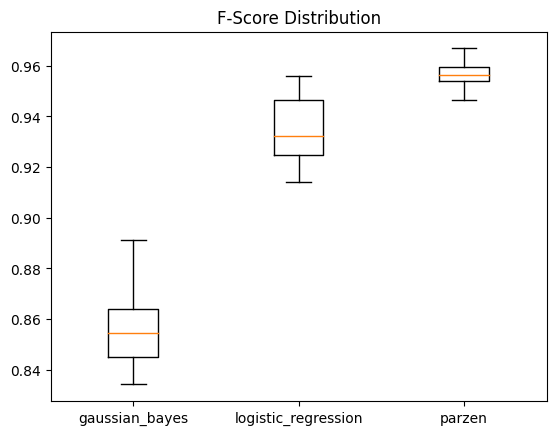

In [112]:
my_dict = {
    'gaussian_bayes': bayesian_gaussian.execs_f_measure.to_list(),
    'logistic_regression': logistic_regression.execs_f_measure.to_list(),
    'parzen': parzen.execs_f_measure.to_list()
}
                                                                      
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
ax.set_title('F-Score Distribution')

Text(0.5, 1.0, 'Accuracy Distribution')

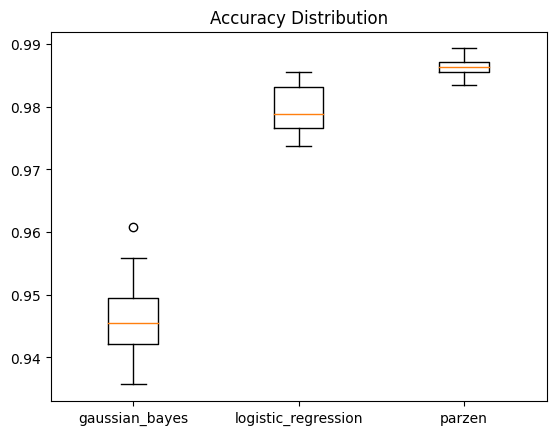

In [114]:
my_dict = {
    'gaussian_bayes': bayesian_gaussian.execs_accuracy.to_list(),
    'logistic_regression': logistic_regression.execs_accuracy.to_list(),
    'parzen': parzen.execs_accuracy.to_list()
}
                                                                      
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
ax.set_title('Accuracy Distribution')

## Cálculo do teste de Friedman para o f-score

In [115]:
friedmanchisquare(
    bayesian_gaussian.execs_f_measure,
    logistic_regression.execs_f_measure, 
    parzen.execs_f_measure
)

FriedmanchisquareResult(statistic=60.0, pvalue=9.357622968840163e-14)

In [136]:
group1 = list(bayesian_gaussian.execs_f_measure)
group2 = list(parzen.execs_f_measure)
group3 = list(logistic_regression.execs_f_measure)

x = np.array([group1,group2,group3]).T
posthoc_nemenyi_friedman(x)

,0,1,2
0,1.000,0.001,0.001
1,0.001,1.000,0.001
2,0.001,0.001,1.000
